In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
import os
#os.chdir('/content/drive/MyDrive')

In [14]:
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [15]:
#! kaggle datasets download -d yacharki/yelp-reviews-for-sentianalysis-binary-np-csv

In [16]:
#!kaggle datasets download -d yacharki/yelp-reviews-for-sentianalysis-binary-np-csv -p /content


In [17]:
#!mv /content/yelp-reviews-for-sentianalysis-binary-np-csv.zip /content/drive/MyDrive/


In [18]:
#!unzip /content/drive/MyDrive/yelp-reviews-for-sentianalysis-binary-np-csv.zip -d /content/drive/MyDrive/

In [19]:
CUDA_LAUNCH_BLOCKING=1
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import preprocessing,tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
#from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [20]:
yelp_train_data = pd.read_csv('/content/drive/MyDrive/yelp_review_sa_binary_csv/train.csv')
yelp_test_data = pd.read_csv('/content/drive/MyDrive/yelp_review_sa_binary_csv/test.csv')


In [21]:
print(yelp_train_data.shape)
print(yelp_test_data.shape)

(560000, 2)
(38000, 2)


**Text Cleaning**

In [22]:
print(yelp_train_data.isnull().sum())
print(yelp_test_data.isnull().sum())

class_index    0
review_text    0
dtype: int64
class_index    0
review_text    0
dtype: int64


In [23]:
yelp_train_data = yelp_train_data[yelp_train_data['review_text'].notna()]
yelp_train_data = yelp_train_data[yelp_train_data['review_text'].str.strip() != ""]

# Get the class distribution in the original data
class_counts = yelp_train_data['class_index'].value_counts(normalize=True)

# Calculate the number of samples per class for a total of 5,000 rows
samples_per_class = (class_counts * 5000).round().astype(int)

# Perform stratified sampling
sampled_data = yelp_train_data.groupby('class_index').apply(lambda x: x.sample(n=samples_per_class[x.name], random_state=42)).reset_index(drop=True)

# Check the class distribution in the sampled data
print(sampled_data['class_index'].value_counts(normalize=True))

class_index
1    0.5
2    0.5
Name: proportion, dtype: float64


<ipython-input-23-6999dce83965>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = yelp_train_data.groupby('class_index').apply(lambda x: x.sample(n=samples_per_class[x.name], random_state=42)).reset_index(drop=True)


In [24]:
sampled_data.to_csv("yelp_train_data.csv", index=False)

In [25]:
yelp_test_data = yelp_test_data[yelp_test_data['review_text'].notna()]
yelp_test_data = yelp_test_data[yelp_test_data['review_text'].str.strip() != ""]

# Get the class distribution in the original data
class_counts = yelp_test_data['class_index'].value_counts(normalize=True)

# Calculate the number of samples per class for a total of 1000 rows
samples_per_class = (class_counts * 1000).round().astype(int)

# Perform stratified sampling
sampled_data = yelp_test_data.groupby('class_index').apply(lambda x: x.sample(n=samples_per_class[x.name], random_state=42)).reset_index(drop=True)

# Check the class distribution in the sampled data
print(sampled_data['class_index'].value_counts(normalize=True))

class_index
1    0.5
2    0.5
Name: proportion, dtype: float64


<ipython-input-25-22511f65c20d>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = yelp_test_data.groupby('class_index').apply(lambda x: x.sample(n=samples_per_class[x.name], random_state=42)).reset_index(drop=True)


In [26]:
sampled_data.to_csv("yelp_test_data.csv", index=False)

In [27]:
def cleaning_text(review):

    #removing the url's
    review = re.sub('http\S+\s*', ' ', review)
    #removing the  punctuations
    review = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>@[\]^_`{|}~?"""), ' ', review)
    #removing non-ascii characters
    review = re.sub(r'[^\x00-\x7f]',r' ', review)
    #removing mentions (i.e, @)
    review = re.sub('@\S+', '  ', review)
    #removing hashtags
    review = re.sub('#\S+', ' ', review)
    #remove numbers
    review = re.sub("\d+", ' ', review)
    #removing extra whitespaces, wherever applicable
    review = re.sub('\s+', ' ',review)
    #converting the text into lowercase
    review = review.lower()

    return review

In [28]:
yelp_train_data = pd.read_csv('yelp_train_data.csv')
yelp_test_data = pd.read_csv('yelp_test_data.csv')

In [29]:
yelp_train_data['clean_review_text'] = yelp_train_data['review_text'].apply(cleaning_text)
yelp_test_data['clean_review_text'] = yelp_test_data['review_text'].apply(cleaning_text)

In [30]:
yelp_train_data.head(5)

,class_index,review_text,clean_review_text
0,1,I do enjoy Taco Bell from time to time but I h...,i do enjoy taco bell from time to time but i h...
1,1,My sister and I are pretty great guest at rest...,my sister and i are pretty great guest at rest...
2,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...,le vrai four u e bois u e l entr u e e u e tai...
3,1,Felt discriminated because I came there in a s...,felt discriminated because i came there in a s...
4,1,Absolutely AWFUL service. \nWe were originally...,absolutely awful service nwe were originally t...


In [31]:
yelp_test_data.head(5)

,class_index,review_text,clean_review_text
0,1,Worst Starbucks I've ever been to! The staff i...,worst starbucks i ve ever been to the staff is...
1,1,F*ck this place. Maybe the location in Tempe i...,f ck this place maybe the location in tempe is...
2,1,"Stayed at the Hakone Suite, room is fantastic ...",stayed at the hakone suite room is fantastic a...
3,1,"This place sucks. It's small, and their adver...",this place sucks it s small and their advertis...
4,1,Ate there for the first and last time. Let me...,ate there for the first and last time let me s...


In [32]:
yelp_train_data.class_index.value_counts()

,count
class_index,
1,2500
2,2500


In [33]:
yelp_test_data.class_index.value_counts()

,count
class_index,
1,500
2,500


**Tokenization**

In [34]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [35]:
yelp_train_data['tokens'] = yelp_train_data['clean_review_text'].apply(word_tokenize)
yelp_test_data['tokens'] = yelp_test_data['clean_review_text'].apply(word_tokenize)

In [36]:
yelp_train_data.head()

,class_index,review_text,clean_review_text,tokens
0,1,I do enjoy Taco Bell from time to time but I h...,i do enjoy taco bell from time to time but i h...,"[i, do, enjoy, taco, bell, from, time, to, tim..."
1,1,My sister and I are pretty great guest at rest...,my sister and i are pretty great guest at rest...,"[my, sister, and, i, are, pretty, great, guest..."
2,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...,le vrai four u e bois u e l entr u e e u e tai...,"[le, vrai, four, u, e, bois, u, e, l, entr, u,..."
3,1,Felt discriminated because I came there in a s...,felt discriminated because i came there in a s...,"[felt, discriminated, because, i, came, there,..."
4,1,Absolutely AWFUL service. \nWe were originally...,absolutely awful service nwe were originally t...,"[absolutely, awful, service, nwe, were, origin..."


 **Remove** **Stopwords**

In [37]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
yelp_train_data['tokens'] = yelp_train_data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
yelp_test_data['tokens'] = yelp_test_data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [39]:
yelp_train_data.head()

,class_index,review_text,clean_review_text,tokens
0,1,I do enjoy Taco Bell from time to time but I h...,i do enjoy taco bell from time to time but i h...,"[enjoy, taco, bell, time, time, hate, say, las..."
1,1,My sister and I are pretty great guest at rest...,my sister and i are pretty great guest at rest...,"[sister, pretty, great, guest, restaurants, ti..."
2,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...,le vrai four u e bois u e l entr u e e u e tai...,"[le, vrai, four, u, e, bois, u, e, l, entr, u,..."
3,1,Felt discriminated because I came there in a s...,felt discriminated because i came there in a s...,"[felt, discriminated, came, suit, clothes, des..."
4,1,Absolutely AWFUL service. \nWe were originally...,absolutely awful service nwe were originally t...,"[absolutely, awful, service, nwe, originally, ..."


In [40]:
yelp_test_data.head()

,class_index,review_text,clean_review_text,tokens
0,1,Worst Starbucks I've ever been to! The staff i...,worst starbucks i ve ever been to the staff is...,"[worst, starbucks, ever, staff, extremely, rud..."
1,1,F*ck this place. Maybe the location in Tempe i...,f ck this place maybe the location in tempe is...,"[f, ck, place, maybe, location, tempe, better,..."
2,1,"Stayed at the Hakone Suite, room is fantastic ...",stayed at the hakone suite room is fantastic a...,"[stayed, hakone, suite, room, fantastic, satis..."
3,1,"This place sucks. It's small, and their adver...",this place sucks it s small and their advertis...,"[place, sucks, small, advertisements, tv, bs, ..."
4,1,Ate there for the first and last time. Let me...,ate there for the first and last time let me s...,"[ate, first, last, time, let, start, saying, f..."


**Lemmatization**

In [41]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [42]:
lemmatizer = WordNetLemmatizer()

yelp_train_data['tokens'] = yelp_train_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
yelp_test_data['tokens'] = yelp_test_data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [43]:
yelp_train_data.head()

,class_index,review_text,clean_review_text,tokens
0,1,I do enjoy Taco Bell from time to time but I h...,i do enjoy taco bell from time to time but i h...,"[enjoy, taco, bell, time, time, hate, say, las..."
1,1,My sister and I are pretty great guest at rest...,my sister and i are pretty great guest at rest...,"[sister, pretty, great, guest, restaurant, tip..."
2,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...,le vrai four u e bois u e l entr u e e u e tai...,"[le, vrai, four, u, e, bois, u, e, l, entr, u,..."
3,1,Felt discriminated because I came there in a s...,felt discriminated because i came there in a s...,"[felt, discriminated, came, suit, clothes, des..."
4,1,Absolutely AWFUL service. \nWe were originally...,absolutely awful service nwe were originally t...,"[absolutely, awful, service, nwe, originally, ..."


In [44]:
yelp_train_data['processed_review'] = yelp_train_data['tokens'].apply(lambda x: ' '.join(x))
yelp_test_data['processed_review'] = yelp_test_data['tokens'].apply(lambda x: ' '.join(x))

In [45]:
yelp_train_data.head()

,class_index,review_text,clean_review_text,tokens,processed_review
0,1,I do enjoy Taco Bell from time to time but I h...,i do enjoy taco bell from time to time but i h...,"[enjoy, taco, bell, time, time, hate, say, las...",enjoy taco bell time time hate say last time f...
1,1,My sister and I are pretty great guest at rest...,my sister and i are pretty great guest at rest...,"[sister, pretty, great, guest, restaurant, tip...",sister pretty great guest restaurant tip well ...
2,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...,le vrai four u e bois u e l entr u e e u e tai...,"[le, vrai, four, u, e, bois, u, e, l, entr, u,...",le vrai four u e bois u e l entr u e e u e tai...
3,1,Felt discriminated because I came there in a s...,felt discriminated because i came there in a s...,"[felt, discriminated, came, suit, clothes, des...",felt discriminated came suit clothes designer ...
4,1,Absolutely AWFUL service. \nWe were originally...,absolutely awful service nwe were originally t...,"[absolutely, awful, service, nwe, originally, ...",absolutely awful service nwe originally told w...


In [46]:
X_train = yelp_train_data['processed_review'].tolist()
y_train = yelp_train_data['class_index'].tolist()

X_test = yelp_test_data['processed_review'].tolist()
y_test = yelp_test_data['class_index'].tolist()

In [47]:
label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_train)))}
y_train = [label_mapping[label] for label in y_train]

label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_test)))}
y_test = [label_mapping[label] for label in y_test]

In [48]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [49]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, labels, max_length=128):
    tokenized = tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return tokenized["input_ids"], tokenized["attention_mask"], torch.tensor(labels)

input_ids, attention_masks, labels = tokenize_data(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [50]:
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [51]:
X_train_ids, X_val_ids, train_masks, val_masks, y_train, y_val = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)


train_dataset = TextDataset(X_train_ids, train_masks, y_train)
val_dataset = TextDataset(X_val_ids, val_masks, y_val)


In [52]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [53]:
torch.cuda.empty_cache()
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [54]:
torch.cuda.is_available()

True

In [55]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [56]:
# Early stopping parameters
early_stopping_patience = 2
best_val_loss = float("inf")
patience_counter = 0

# Lists to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []


In [57]:
epochs = 20
best_val_accuracy = 0  # Initialize for early stopping

for epoch in range(epochs):
    # Training Phase
    model.train()
    total_loss = 0
    train_predictions = []
    train_labels = []

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Track training predictions and labels
        preds = torch.argmax(outputs.logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_score(train_labels, train_predictions)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation Phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss or val_accuracy > best_val_accuracy:
        best_val_loss = avg_val_loss
        best_val_accuracy = val_accuracy
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break


Epoch 1, Training Loss: 0.3651, Training Accuracy: 0.8365
Epoch 1, Validation Loss: 0.3097, Validation Accuracy: 0.8670
Epoch 2, Training Loss: 0.1908, Training Accuracy: 0.9267
Epoch 2, Validation Loss: 0.3295, Validation Accuracy: 0.8710
Epoch 3, Training Loss: 0.1010, Training Accuracy: 0.9647
Epoch 3, Validation Loss: 0.3925, Validation Accuracy: 0.8910
Epoch 4, Training Loss: 0.0406, Training Accuracy: 0.9875
Epoch 4, Validation Loss: 0.3416, Validation Accuracy: 0.8920
Epoch 5, Training Loss: 0.0452, Training Accuracy: 0.9855
Epoch 5, Validation Loss: 0.4495, Validation Accuracy: 0.8870
No improvement for 1 epoch(s).
Epoch 6, Training Loss: 0.0294, Training Accuracy: 0.9892
Epoch 6, Validation Loss: 0.4842, Validation Accuracy: 0.8810
No improvement for 2 epoch(s).
Early stopping triggered.


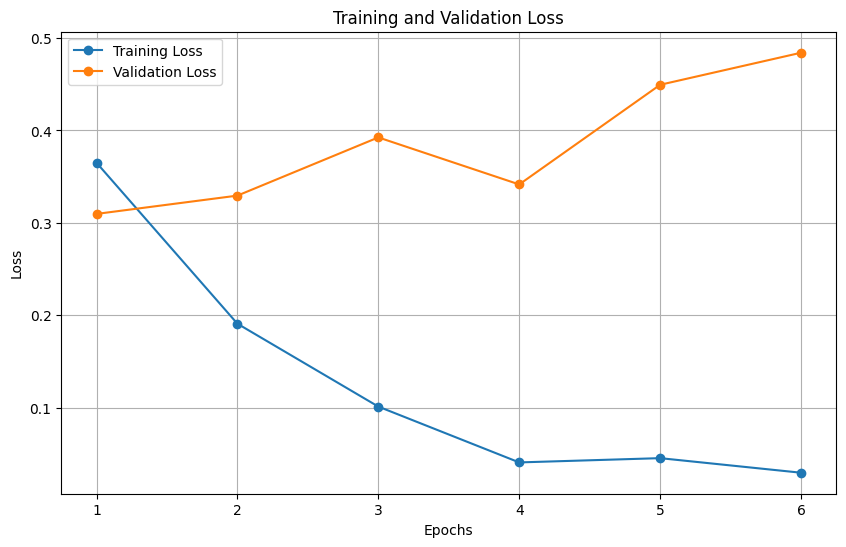

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
model.save_pretrained("bert-finetuned-model")
tokenizer.save_pretrained("bert-finetuned-model")

('bert-finetuned-model/tokenizer_config.json',
 'bert-finetuned-model/special_tokens_map.json',
 'bert-finetuned-model/vocab.txt',
 'bert-finetuned-model/added_tokens.json')

In [60]:
input_ids, attention_mask, labels = tokenize_data(X_test,y_test)

model.eval()
with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()


print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Positive - class 1", "Negative - class 0"]))

Classification Report:
                    precision    recall  f1-score   support

Positive - class 1       0.87      0.93      0.90       500
Negative - class 0       0.92      0.86      0.89       500

          accuracy                           0.90      1000
         macro avg       0.90      0.90      0.89      1000
      weighted avg       0.90      0.90      0.89      1000



In [78]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

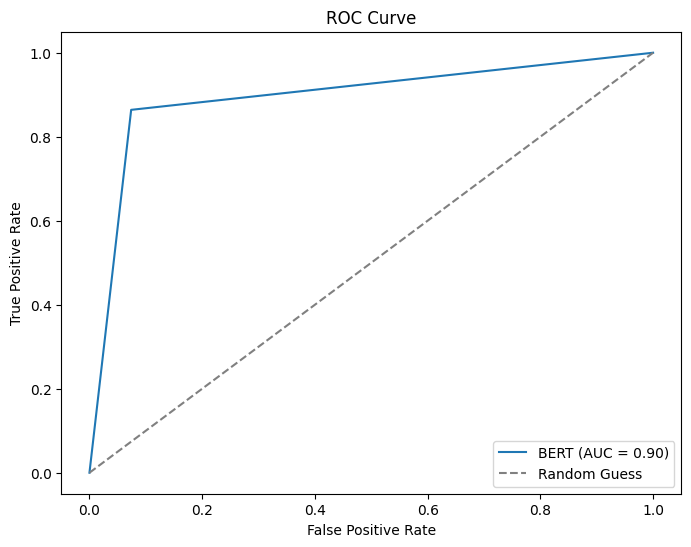

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'BERT (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

<Figure size 800x600 with 0 Axes>

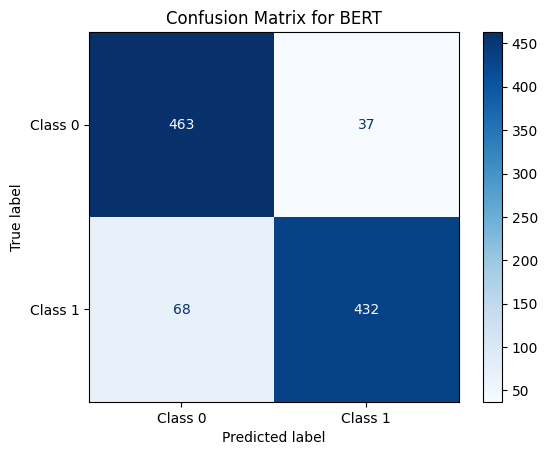

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_bert = confusion_matrix(y_test, predictions)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=["Class 0", "Class 1"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp_bert.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for BERT")
plt.show()

In [62]:
X_train = yelp_train_data['processed_review'].tolist()
y_train = yelp_train_data['class_index'].tolist()

X_test = yelp_test_data['processed_review'].tolist()
y_test = yelp_test_data['class_index'].tolist()

In [63]:
label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_train)))}
y_train = [label_mapping[label] for label in y_train]

label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_test)))}
y_test = [label_mapping[label] for label in y_test]

In [64]:
def tf_idf_vect(train_data,test_data):

    #Initialising the tf-idf vectorizer
    #df:When building the vocabulary it ignores the terms that have a document frequency strictly lower than the given threshold(df=5)
    vectorizer = TfidfVectorizer(min_df=8)
    #fit_transform learns the vocabulary dictionary and return document-term matrix.
    train_cv = vectorizer.fit_transform(train_data)
    #Transform documents to document-term matrix
    test_cv = vectorizer.transform(test_data)

    return train_cv,test_cv

In [65]:
X_train, X_test = tf_idf_vect(X_train,X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'nb__alpha': 10}
Best cross-validation score: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       500
           1       0.85      0.83      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

ROC-AUC Score: 0.924264


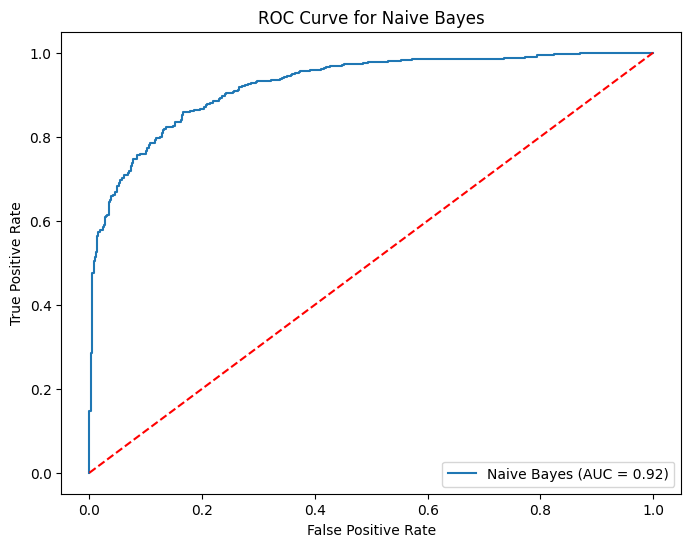

In [66]:
# Define the pipeline with Multinomial Naive Bayes
pipeline_nb = Pipeline([
    ('nb', MultinomialNB())
])

# Define the parameter grid for GridSearchCV
param_grid_nb = {
    'nb__alpha': [0.01, 0.1, 1, 10]  # Smoothing parameter for Naive Bayes
}

# Setup GridSearchCV
grid_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='accuracy', verbose=1)

# Train the model with GridSearchCV on the training data
grid_nb.fit(X_train, y_train)  # assuming y_train contains the labels for training

# Best model, predict, and evaluate
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)
y_prob_nb = best_nb.predict_proba(X_test)[:, 1]  # Probability scores for ROC curve

# Display best parameters and cross-validation score
print("Best parameters:", grid_nb.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_nb.best_score_))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))  # assuming y_test contains the labels for testing

# Print ROC-AUC score
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_nb))

# Plot ROC curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_nb))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

<Figure size 800x600 with 0 Axes>

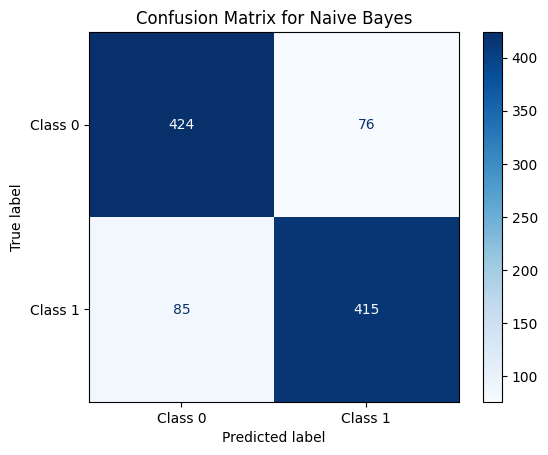

In [69]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["Class 0", "Class 1"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp_nb.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Naive Bayes")
plt.show()

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the pipeline with Decision Tree
pipeline_dt = Pipeline([
    ('dt', DecisionTreeClassifier())  # Basic Decision Tree Classifier
])

# Define the parameter grid for GridSearchCV
param_grid_dt = {
    'dt__max_depth': [3, 5, 10],
    'dt__min_samples_split': [2, 5],  # Minimum samples required to split an internal node
    'dt__min_samples_leaf': [1, 2, 4],   # Minimum samples required to be at a leaf node
}

# Setup GridSearchCV
grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='accuracy', verbose=1)

# Train the model with GridSearchCV on the training data
grid_dt.fit(X_train, y_train)  # Assuming X_train and y_train are defined

# Get the best model
best_dt = grid_dt.best_estimator_

# Predict on the test set
y_pred_dt = best_dt.predict(X_test)  # Assuming X_test is defined
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]  # Probability scores for the positive class (1)

# Display the best parameters and cross-validation score
print("Best parameters:", grid_dt.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_dt.best_score_))



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}
Best cross-validation score: 0.74



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       500
           1       0.78      0.61      0.69       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000

ROC-AUC Score: 0.7360719999999998


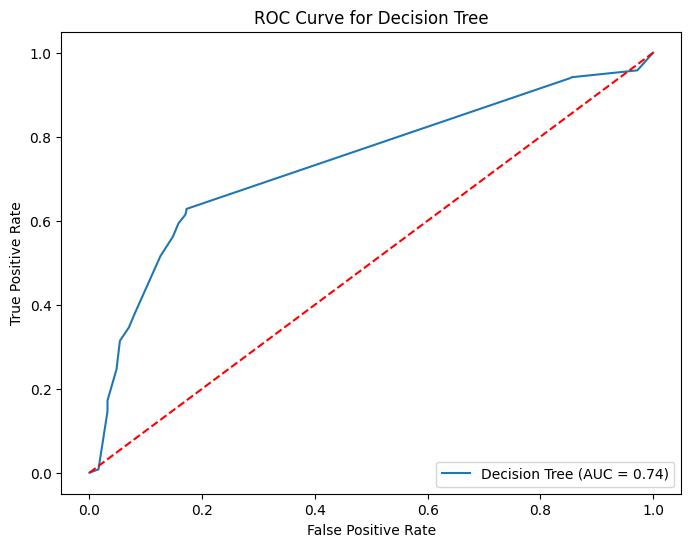

In [68]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob_dt)
print("ROC-AUC Score:", roc_auc)

# Compute the ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt, pos_label=1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="lower right")
plt.show()




<Figure size 800x600 with 0 Axes>

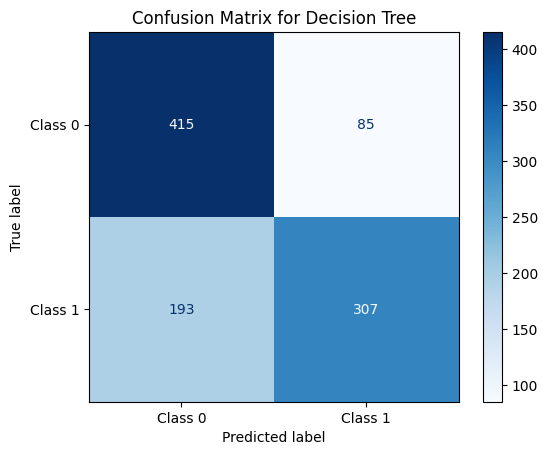

In [71]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Class 0", "Class 1"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp_dt.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best cross-validation score: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       500
           1       0.89      0.85      0.87       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

ROC-AUC Score: 0.947784


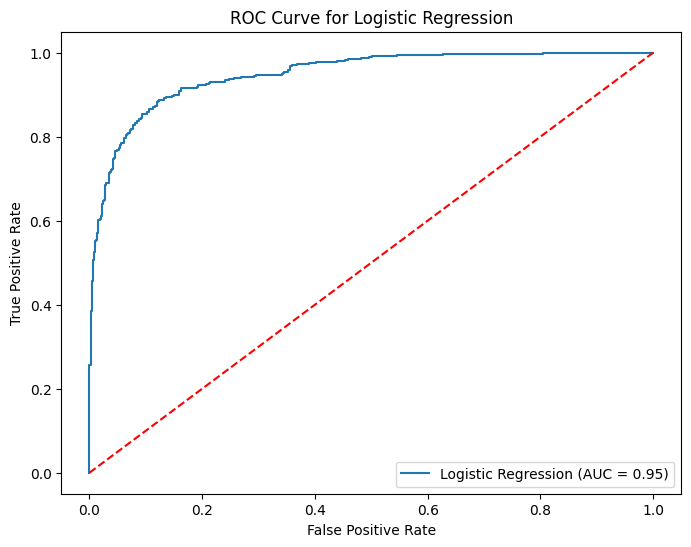

In [73]:
# Define the pipeline with Logistic Regression
pipeline_lr = Pipeline([
    ('logreg', LogisticRegression(solver='liblinear'))  # 'liblinear' solver is suitable for binary classification
])

# Define the parameter grid for GridSearchCV
param_grid_lr = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2']        # L1 and L2 regularization
}

# Setup GridSearchCV
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy', verbose=1)
# Train the model with GridSearchCV on the training data
grid_lr.fit(X_train, y_train)  # assuming y_train contains the labels for training

# Best model, predict and evaluate
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]  # Probability scores for ROC curve

# Display best parameters and cross-validation score
print("Best parameters:", grid_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_lr.best_score_))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))  # assuming y_test contains the labels for testing

# Print ROC-AUC score
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr,pos_label =1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % roc_auc_score(y_test, y_prob_lr))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

<Figure size 800x600 with 0 Axes>

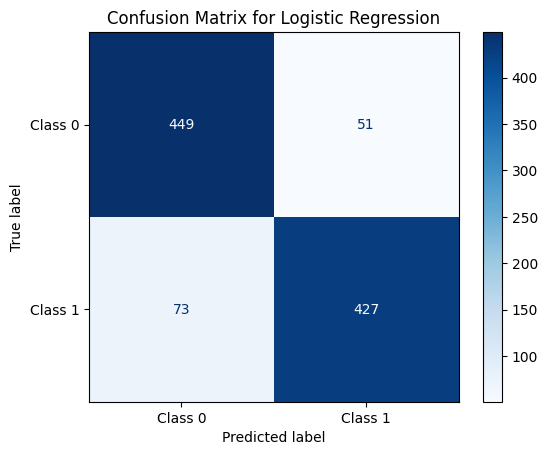

In [75]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Class 0", "Class 1"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp_lr.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()